In [9]:
import os
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks, Input, Model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter

In [2]:
def load_npz_data(data_dir, prefix):
    Xfile = np.load(f"{data_dir}/X_{prefix}_beats.npz")
    Zfile = np.load(f"{data_dir}/Z_{prefix}_beats.npz")
    # Ambil array pertama (apapun key-nya)
    X = Xfile[Xfile.files[0]]
    Z = Zfile[Zfile.files[0]]
    return X, Z

def minmax_normalize_beats(X_beats):
    # X_beats shape: (n_beats, 55, 12)
    min_val = X_beats.min(axis=1, keepdims=True)  # shape (n_beats, 1, 12)
    max_val = X_beats.max(axis=1, keepdims=True)
    X_norm = (X_beats - min_val) / (max_val - min_val + 1e-8)
    return X_norm

def denoise_beats(X_beats, window_length=7, polyorder=2):
    # X_beats shape: (n_beats, 55, 12)
    denoised = savgol_filter(X_beats, window_length=window_length, polyorder=polyorder, axis=1)
    return denoised


In [3]:
data_dir = 'data_ready'
X_train, Z_train = load_npz_data(data_dir, 'train')
X_val, Z_val = load_npz_data(data_dir, 'valid')
X_test, Z_test = load_npz_data(data_dir, 'test')


# Normalize each beat
X_train = minmax_normalize_beats(X_train)
X_val = minmax_normalize_beats(X_val)
X_test = minmax_normalize_beats(X_test)

y_train = Z_train
y_val = Z_val
y_test = Z_test
print("Train beats :", X_train.shape, y_train.shape)
print("Valid beats :", X_val.shape, y_val.shape)
print("Test beats  :", X_test.shape, y_test.shape)

Train beats : (170370, 55, 12) (170370, 5)
Valid beats : (48370, 55, 12) (48370, 5)
Test beats  : (24257, 55, 12) (24257, 5)


In [4]:
# Denoising
X_train_denoised = denoise_beats(X_train)
X_val_denoised = denoise_beats(X_val)
X_test_denoised = denoise_beats(X_test)

# Normalisasi
X_train_filtered = minmax_normalize_beats(X_train_denoised)
X_val_filtered = minmax_normalize_beats(X_val_denoised)
X_test_filtered = minmax_normalize_beats(X_test_denoised)

cek data

In [5]:
label_beat_pertama = Z_train[12220]
print(label_beat_pertama)

[1 0 0 0 0]


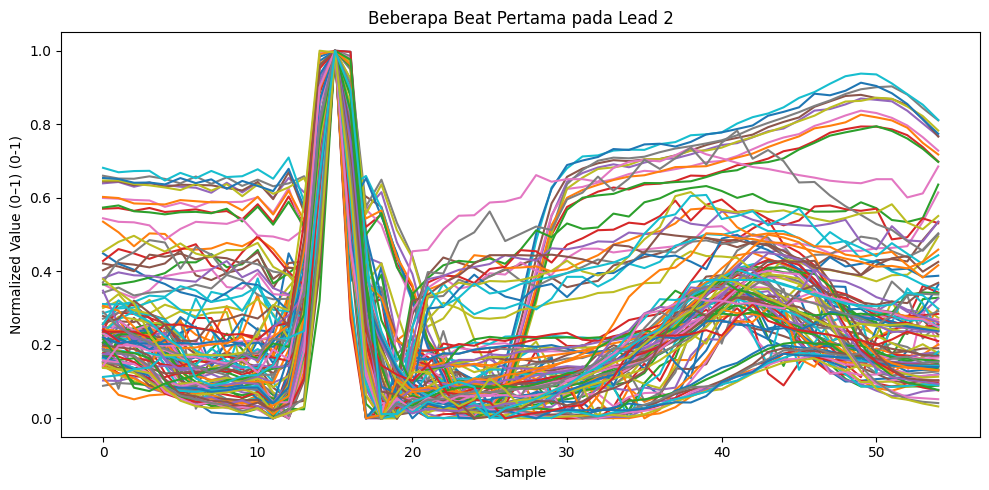

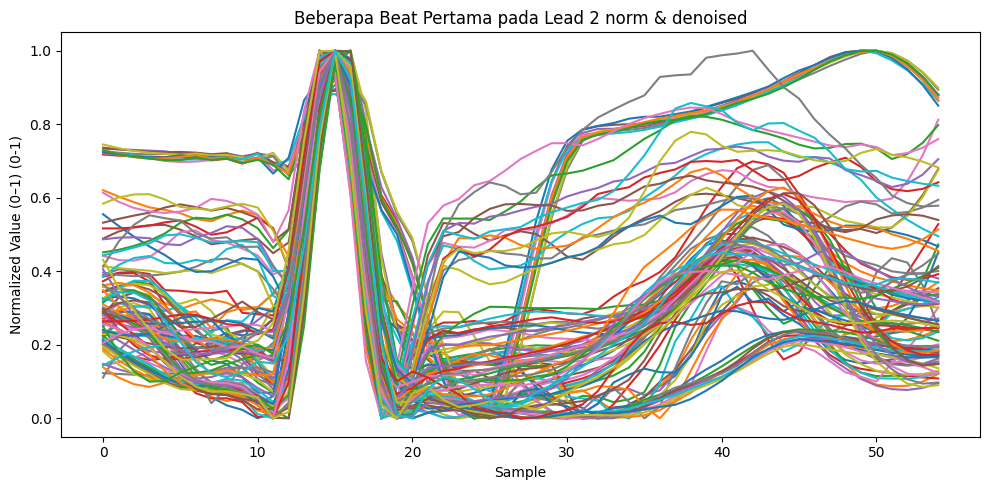

In [ ]:
import matplotlib.pyplot as plt

lead_index = 1  # Change dengan indeks lead yang ingin dilihat (for example: 0 for lead 1, 1 for lead 2, dst)
n_show = 100      # Berapa beat yang ingin diDisplay


plt.figure(figsize=(100, 5))
for i in range(n_show):
    plt.plot(X_train[i][:, lead_index], label=f'Beat {i+1} ')

plt.title(f'Beberapa Beat Pertama pada Lead {lead_index+1}')
plt.xlabel("Sample")
plt.ylabel("Normalized Value (0–1) (0-1)")
# plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for i in range(n_show):
    plt.plot(X_train_filtered[i][:, lead_index], label=f'Beat {i+1} ')

plt.title(f'Beberapa Beat Pertama pada Lead {lead_index+1} norm & denoised')
plt.xlabel("Sample")
plt.ylabel("Normalized Value (0–1) (0-1)")
# plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()




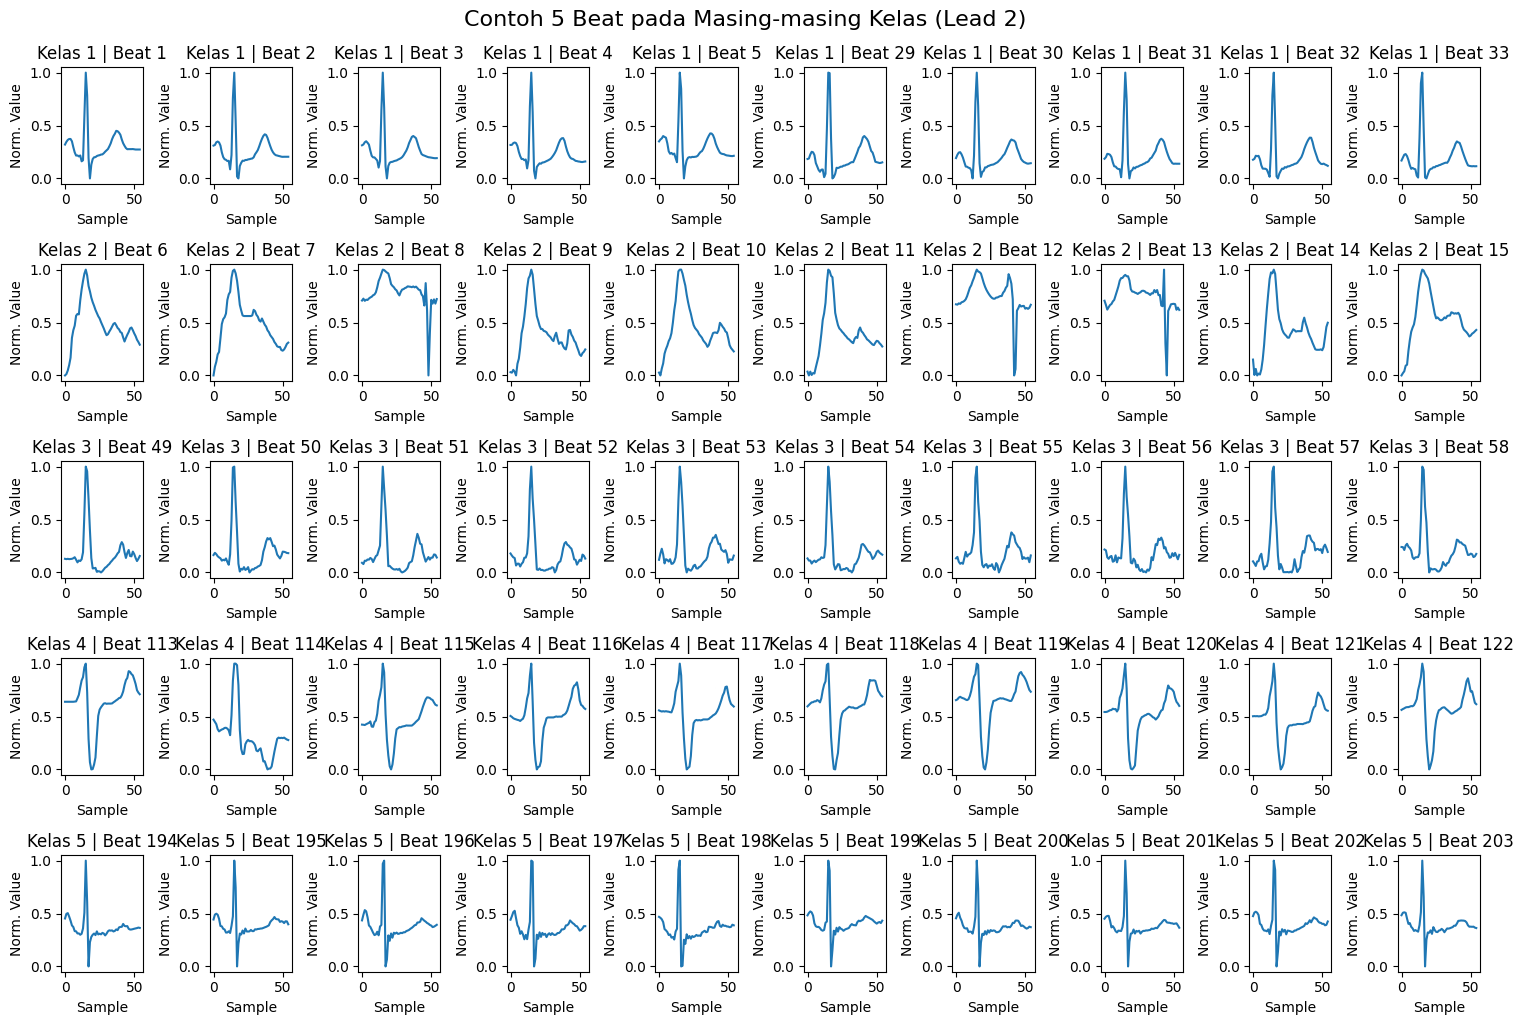

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Misal X = X_train, Z = y_train (atau sesuaikan)
n_look = 10000
n_class = 5
n_show = 10            # beat yang mau di plot per kelas
lead_index = 1        # indeks lead (0 = lead 1, dst)

X = X_train[10000:20000]
Z = y_train[10000:20000]

plt.figure(figsize=(15, 10))

for cls in range(n_class):
    # Cari index yang labelnya = kelas cls
    idxs = np.where(Z.argmax(axis=1) == cls)[0][:n_show]
    for i, idx in enumerate(idxs):
        plt.subplot(n_class, n_show, cls * n_show + i + 1)
        plt.plot(X[idx][:, lead_index])
        plt.title(f'Kelas {cls+1} | Beat {idx+1}')
        plt.xlabel('Sample')
        plt.ylabel('Norm. Value')
        plt.tight_layout()
plt.suptitle(f'Contoh 5 Beat pada Masing-masing Kelas (Lead {lead_index+1})', fontsize=16, y=1.02)
plt.show()


model making

In [10]:
input_shape = (55, 12)
num_classes = 5

inputs = Input(shape=input_shape)

# --- CNN Feature Extractor 32-64-128-256 ---
x = layers.Conv1D(32, 5, activation='relu', padding='same')(inputs)
x = layers.MaxPooling1D(2)(x)

x = layers.Conv1D(64, 5, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(2)(x)

x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(2)(x)

x = layers.Conv1D(256, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(2)(x)

x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# --- LSTM + Temporal Attention ---
x = layers.LSTM(128, return_sequences=True)(x)

# Attention
attention = layers.Dense(1, activation='tanh')(x)            # (batch, time, 1)
attention = layers.Flatten()(attention)                      # (batch, time)
attention = layers.Activation('softmax')(attention)          # (batch, time)
attention = layers.RepeatVector(128)(attention)              # (features, batch, time)
attention = layers.Permute([2, 1])(attention)                # (batch, time, features)
attended_x = layers.Multiply()([x, attention])               # (batch, time, features)
x = layers.Lambda(lambda z: tf.reduce_sum(z, axis=1))(attended_x)   # (batch, features)

# --- Fully Connected Classifier ---
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 55, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 55, 32)    │      1,952 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 27, 32)    │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 27, 64)    │     10,304 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 13, 64)    │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 13, 128)   │     24,704 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 6, 128)    │          0 │ conv1d_6[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 6, 256)    │     98,560 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 3, 256)    │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 256)    │      1,024 │ max_pooling1d_7[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 3, 256)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 3, 128)    │    197,120 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3, 1)      │        129 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 3)         │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 3)         │          0 │ flatten_1[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 128, 3)    │          0 │ activation_1[0][… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_1 (Permute) │ (None, 3, 128)    │          0 │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 3, 128)    │          0 │ lstm_1[0][0],     │
│ (Multiply)          │                   │            │ permute_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128)       │          0 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     16,512 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 350,950 (1.34 MB)

 Trainable params: 350,438 (1.34 MB)

 Non-trainable params: 512 (2.00 KB)

In [11]:
# 4. Training with early stopping and checkpointing
cb = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    callbacks.ModelCheckpoint('cnn_lstm_best.keras', save_best_only=True, monitor='val_loss')
]

history = model.fit(
    X_train_filtered, Z_train,
    epochs=30,
    batch_size=128,
    validation_data=(X_val, Z_val),
    callbacks=cb
)

Epoch 1/30
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.3600 - loss: 9.6442 - val_accuracy: 0.0920 - val_loss: 4.8809
Epoch 2/30
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.2696 - loss: 5.6058 - val_accuracy: 0.0920 - val_loss: 13.9322
Epoch 3/30
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.2652 - loss: 8.4967 - val_accuracy: 0.4495 - val_loss: 19.0075
Epoch 4/30
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.2642 - loss: 11.3705 - val_accuracy: 0.1829 - val_loss: 31.2023
Epoch 5/30
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.2629 - loss: 15.0190 - val_accuracy: 0.0243 - val_loss: 10.3035
Epoch 6/30
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.2629 - loss: 16.7051 - val_accuracy: 0.4495 - val_loss: 18.2532
Epoch 7/30
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.2627 - loss: 20.3201 - val_accuracy: 0.0770 - val_loss: 40.2047
Epoch 8/30
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy

KeyboardInterrupt: 

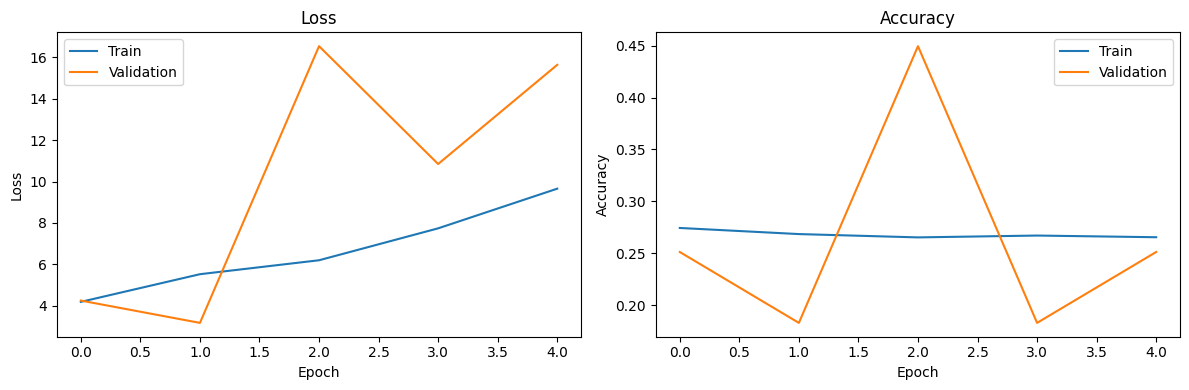

Test Loss: 3.1481, Test Accuracy: 0.1739
759/759 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11006
           1       0.00      0.00      0.00      6277
           2       0.17      1.00      0.30      4219
           3       0.00      0.00      0.00      2149
           4       0.00      0.00      0.00       606

    accuracy                           0.17     24257
   macro avg       0.03      0.20      0.06     24257
weighted avg       0.03      0.17      0.05     24257



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


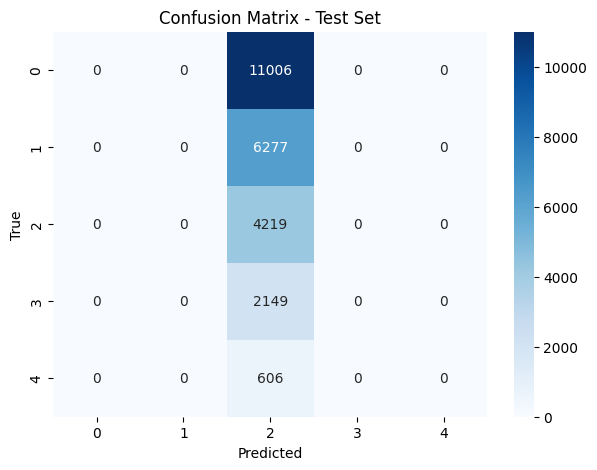

In [ ]:
# 5. Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# 6. Evaluate model on test set
score = model.evaluate(X_test, Z_test, verbose=0)
print(f"Test Loss: {score[0]:.4f}, Test Accuracy: {score[1]:.4f}")

# 7. Classification report and confusion matrix
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(Z_test, axis=1)

print(classification_report(y_true_labels, y_pred_labels))

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

TESTTT

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

model_lstm = Sequential()

# LSTM layer, tambahkan return_sequences=False karena langsung ke FC
model_lstm.add(LSTM(128, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.3))

# Dense classifier
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5, activation='softmax'))  # 5 kelas (one-hot)

model_lstm.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_lstm.summary()


c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │        72,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,773 (315.52 KB)

 Trainable params: 80,773 (315.52 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
history = model_lstm.fit(
    X_train_filtered, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)
loss, acc = model_lstm.evaluate(X_test, y_test)
print(f'Test Accuracy: {acc:.4f}')


Epoch 1/5
2663/2663 ━━━━━━━━━━━━━━━━━━━━ 79s 29ms/step - accuracy: 0.2865 - loss: 4.9784 - val_accuracy: 0.1829 - val_loss: 4.7550
Epoch 2/5
2663/2663 ━━━━━━━━━━━━━━━━━━━━ 79s 30ms/step - accuracy: 0.2719 - loss: 4.6902 - val_accuracy: 0.0920 - val_loss: 9.4801
Epoch 3/5
2663/2663 ━━━━━━━━━━━━━━━━━━━━ 76s 28ms/step - accuracy: 0.2621 - loss: 7.8420 - val_accuracy: 0.1829 - val_loss: 12.6368
Epoch 4/5
2663/2663 ━━━━━━━━━━━━━━━━━━━━ 75s 28ms/step - accuracy: 0.2627 - loss: 10.2700 - val_accuracy: 0.2512 - val_loss: 26.1463
Epoch 5/5
2663/2663 ━━━━━━━━━━━━━━━━━━━━ 83s 31ms/step - accuracy: 0.2657 - loss: 13.9349 - val_accuracy: 0.4495 - val_loss: 35.0545
759/759 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.1567 - loss: 4.6494
Test Accuracy: 0.1739
